In [1]:
import torch 
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import numpy as np

# Hyper Parameters
layerDimensions = [784, 128, 64, 2]
num_epochs = 20
batch_size = 128
learningRate = 0.01
numberOfLabels = 2
sample_size = 128

# Image Preprocessing 
transform = transforms.Compose([
    transforms.ToTensor()])
#    ,transforms.Normalize((0.4914, 0.4822, 0.4465),
#                          (0.247, 0.2434, 0.2615)),])

# MNIST Dataset
train_dataset = dsets.MNIST(root='./data/',
                            train=True,
                            download=True,
                            transform=transform)


test_dataset = dsets.MNIST(root='./data/',
                           train=False,
                           download=True,
                           transform=transform)

#train_subset = torch.utils.data.Subset(train_dataset, np.arange(sample_size))
train_subset = (train_dataset.data.clone().detach())[:128]

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_subset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=10000,
                                          shuffle=False)



In [2]:
class NN():
    ### Initialize the neural network
    def __init__(self, layerDimensions, epochs, learningRate):
        self.accuracy = []
        self.layerDimensions = layerDimensions
        self.epochs = epochs
        self.learningRate = learningRate
        self.parameters = {}
        self.mean_loss_train = []
        self.mean_loss_test = []
        ### Initializes randoms weights and biases parameters
        L = len(layerDimensions)
        for i in range(1, L):
            self.parameters['W' + str(i)] = np.random.randn(layerDimensions[i], layerDimensions[i - 1]) * np.sqrt(1.0 / layerDimensions[i])

            
    ### Activations functions
    # 1: Sigmoid Function and his derivative
    def sigmoid(self, Z):
        return (np.exp(np.dot(-1, Z))) / ((np.exp(np.dot(-1, Z)) + 1) ** 2)

    def sigmoidDerivative(self, Z):
        return 1 / (1 + np.exp(np.dot(-1, Z)))
        
    # 2: Relu function and his derivative
    def relu(self, Z):
        temp = []
        for i in Z:
            temp.append(max(i, 0))
        return np.array(temp)
    
    def reluDerivative(self, Z):
        temp = []
        for i in Z:
            if i > 0:
                temp.append(1)
            else:
                temp.append(0)
        return np.array(temp)

    # 3: Softmax function and his derivative
    def softmax(self, Z):
        exps = np.exp(Z - Z.max())
        return exps / np.sum(exps, axis=0)
        
    def softmaxDerivative(self, Z):
        exps = np.exp(Z - Z.max())
        return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))

    ### Forward propagation
    def forwardP(self, X_train):
        # Calculate parameters for input layer
        self.parameters['A0'] = X_train
        
        # Calculate parameters for hidden layer 1
        self.parameters['Z1'] = np.dot(self.parameters["W1"], self.parameters['A0'])
        self.parameters['A1'] = self.relu(self.parameters['Z1'])
        
        # Calculate parameters for hidden layer 2
        self.parameters['Z2'] = np.dot(self.parameters["W2"], self.parameters['A1'])
        self.parameters['A2'] = self.relu(self.parameters['Z2'])
        
        # Calculate parameters for hidden layer 3
        self.parameters['Z3'] = np.dot(self.parameters["W3"], self.parameters['A2'])
        self.parameters['A3'] = self.softmax(self.parameters['Z3'])
        return self.parameters['A3']

    
    ### Backward propagation
    def backwardP(self, labels, y_predict): 
        changed_w = {}
        
        # Calculate W3 update
        # loss function: Binary Cross Entropy Function
        #numberOfLabels = y_predict.shape[0]
        #dMst = 2 * (y_predict - y_train) / numberOfLabels
        
        dBce = -labels/y_predict + (1-labels)/(1-y_predict)
        error = dBce * self.softmaxDerivative(self.parameters['Z3'])
        changed_w['W3'] = np.outer(error, self.parameters['A2'])

        # Calculate W2 update
        error = np.dot(self.parameters['W3'].T, error) * self.reluDerivative(self.parameters['Z2'])
        changed_w['W2'] = np.outer(error, self.parameters['A1'])

        # Calculate W1 update
        error = np.dot(self.parameters['W2'].T, error) * self.reluDerivative(self.parameters['Z1'])
        changed_w['W1'] = np.outer(error, self.parameters['A0'])

        return changed_w

    ### Update parameters
    def update_parameters(self, gradients):
        for key, value in gradients.items():
            self.parameters[key] -= self.learningRate * value
            

    
    def crossEntropy(self, y_true, y_pred):
        n = len(y_true)
        summ = 0
        for i in range(n):
            summ += (y_true[i]*np.log(y_pred[i])) + (1-y_true[i])*(np.log(1-y_pred[i]))
        loss = -summ/n
        return loss


    ### Train the data
    def train(self, train_list, test_list, arrPropabilityTrain, arrPropabilityTest, numberOfLabels):
        for i in range(0,self.epochs):
            counter = 0
            predictions = []
            iteration = i +1
            print(f'{iteration}/{self.epochs}')
            for x in train_list:
                X_train = x
                y_train = arrPropabilityTrain[counter]
                counter += 1
                # scale and shift the inputs
                inputs = (np.asfarray(X_train) / 255.0 * 0.99) + 0.01
                # create the target output values (all 0.01, except the desired label which is 0.99)
                labels = np.zeros(numberOfLabels) + 0.01
                labels[int(y_train)] = 0.99
                y_predict = self.forwardP(np.array(inputs).flatten())
                pred = y_predict[int(y_train)]
                predictions.append(pred)
                gradients = self.backwardP(labels, y_predict)
                self.update_parameters(gradients)
            for i in range(len(predictions)):
                if int(arrPropabilityTrain[i]) == 0:
                    predictions[i] = 1-predictions[i]
            loss_train = self.crossEntropy(arrPropabilityTrain, predictions)
            self.mean_loss_train.append(loss_train)
            loss_test = self.test(test_list,arrPropabilityTest, numberOfLabels)
            self.mean_loss_test.append(loss_test)

    # def lossConvergence():
    #     epochs = self.epochs
    #     lossForEpoch = self.mean_loss
    #     print(lossForEpoch)

    ### Compute accuracy
    def test(self, test_data, arrPropabilityTest, numberOfLabels):
        counter = 0
        predictions = []
        for x in test_data:
            X_test, temp = x
            y_test = arrPropabilityTest[counter]
            counter += 1
            inputs = (np.asfarray(X_test) / 255.0 * 0.99) + 0.01
            # create the target output values (all 0.01, except the desired label which is 0.99)
            labels = np.zeros(numberOfLabels) + 0.01
            labels[int(y_test)] = 0.99
            y_predict = self.forwardP(np.array(inputs).flatten())
            pred = y_predict[int(y_test)]
            predictions.append(pred)
        for i in range(len(predictions)):
            if int(arrPropabilityTest[i]) == 0:
                predictions[i] = 1 - predictions[i]
        loss_test = self.crossEntropy(arrPropabilityTest, predictions)
        return loss_test
            


In [3]:
# Create an array of 128 labels binary.
# Each entry in the array corresponds to an image in the train_subset
bernoulli_arr_train = np.random.binomial(n = 1, p = 0.5, size=sample_size)
bernoulli_arr_train_float = np.array(bernoulli_arr_train, dtype=float)
bernoulli_arr_test = np.random.binomial(n=1, p =0.5, size=len(test_dataset))
bernoulli_arr_test_float = np.array(bernoulli_arr_test, dtype=float)

In [4]:
nn1 = NN(layerDimensions, num_epochs, learningRate)
nn1.train(train_subset, test_dataset, bernoulli_arr_train_float,bernoulli_arr_test_float, numberOfLabels)

1/20
2/20
3/20
4/20
5/20
6/20
7/20
8/20
9/20
10/20
11/20
12/20
13/20
14/20
15/20
16/20
17/20
18/20
19/20
20/20


In [5]:
print(nn1.mean_loss_train)
print(nn1.mean_loss_test)

[1.3064636023084122, 0.574917609062323, 0.39766590206695457, 0.27797734708771665, 0.196286447584235, 0.1522901429356072, 0.11449287142532281, 0.09298655919682385, 0.08050648174659396, 0.06652066655883761, 0.05824130077850176, 0.05348860926273458, 0.048672361262369526, 0.043554118685157614, 0.040270174740866756, 0.0396082892819432, 0.034738515805841905, 0.03171790171427236, 0.029176341463682566, 0.027431944898924573]
[0.6933915379103136, 0.6932844139390095, 0.6933239449122333, 0.693231233612712, 0.6932365357627542, 0.6932119513149355, 0.6931609150359065, 0.6931331633802934, 0.6931340110585571, 0.6931249143442351, 0.6931226163421578, 0.6931318371344276, 0.6931270274529606, 0.6931375129704778, 0.693139503512477, 0.6931372552584408, 0.6931381967552663, 0.6931397041398156, 0.6931387939936416, 0.693139475332173]


In [6]:
mean_loss_value_test = np.mean(nn1.mean_loss_test)
mean_loss_value_test

0.6931792272081394

In [9]:
# import pickle
# net_and_labels = {'train_labels': bernoulli_arr_train_float, 'test_labels': bernoulli_arr_test_float, 'net':nn1, 'loss':mean_loss_value_test}
# pickle.dump(net_and_labels, open('model_q2.pkl','wb'))

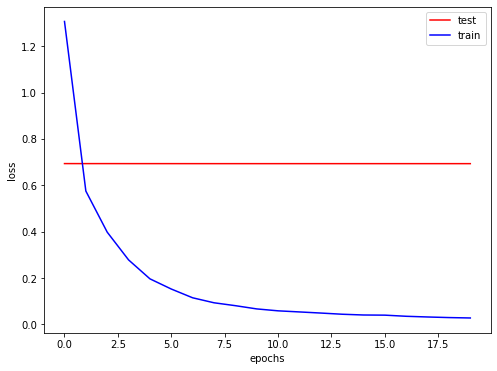

In [8]:
# code for the plots:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(range(20), nn1.mean_loss_test, c='red')
plt.xlabel('epochs')
plt.ylabel('loss')

plt.plot(range(20), nn1.mean_loss_train, c='blue')
plt.xlabel('epochs')
plt.ylabel('loss')

plt.legend(['test', 'train'])

plt.show()